In [14]:
%load_ext autoreload
%autoreload 2

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc

mpl.style.use("ggplot")
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

rc("text", usetex=True)

import os
import re
import sys
import warnings

warnings.filterwarnings("ignore")

from workflow import utils, utils_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_parameters(filename):
    """Get parameter values from the filename."""
    filename = os.path.splitext(os.path.basename(filename))[0]
    filename = filename.replace("-", "|").replace("_", "|")

    res = {}
    for r in filename.split("|"):
        k_v = r.split("=")
        if len(k_v) != 2:
            continue

        k = k_v[0]
        v = k_v[1]

        try:
            v = int(v)
        except ValueError:
            try:
                v = float(v)
            except ValueError:
                pass

        res[k] = v
    return res

In [11]:
dtu_time = "../data/res-dtu/seir/plot-data-time-vs-infected.csv"
dtu_ps = "../data/res-dtu/seir/plot-data-ps-vs-infected.csv"
outputfile = "../figs/sim_result_dtu.pdf"
outputfile_data = "../figs/sim_result_dtu.csv"

# Data

In [12]:
data_table = pd.read_csv(dtu_time, sep="\t")
data_table["time"] /= 12 * 24  # convert to a daily scale

In [13]:
data_table_ps = pd.read_csv(dtu_ps, sep="\t")

# Make layout

In [15]:
def set_layout():
    fig = plt.figure(figsize=(8, 6))

    gs_master = GridSpec(
        nrows=1, ncols=2, hspace=0.2, wspace=0.3, width_ratios=[1, 0.7]
    )

    # time vs infected nodes
    gs = GridSpecFromSubplotSpec(
        nrows=3,
        ncols=1,
        subplot_spec=gs_master[0, 0],
        height_ratios=[1, 0.65, 0.65],
        hspace=0.1,
    )
    ax_t_vs_i = fig.add_subplot(gs[0, 0])
    ax_t_vs_i_ct = fig.add_subplot(gs[1, 0])
    ax_t_vs_i_ps = fig.add_subplot(gs[2, 0])

    # Plots for isolated cases and prevented cases
    gs = GridSpecFromSubplotSpec(
        nrows=3, ncols=1, subplot_spec=gs_master[:, 1], height_ratios=[1, 1, 1],
    )
    ax_ps_vs_i = fig.add_subplot(gs[0, 0])
    ax_ps_vs_p = fig.add_subplot(gs[1, 0])
    ax_ps_vs_e = fig.add_subplot(gs[2, 0])

    return (
        fig,
        ax_t_vs_i,
        ax_t_vs_i_ct,
        ax_t_vs_i_ps,
        ax_ps_vs_i,
        ax_ps_vs_p,
        ax_ps_vs_e,
    )

# Plot

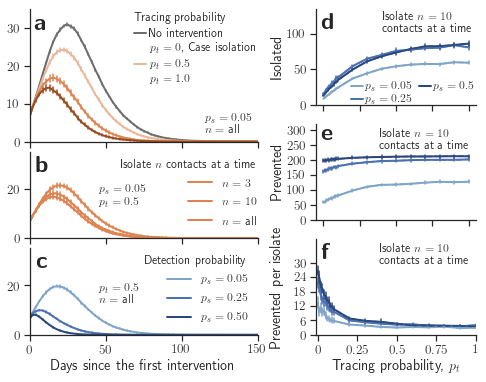

In [22]:
## sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Parameters
plot_params = {
    "markersize": 8,
    # "ci": None,
    # "estimator": np.median,
    "err_style": "bars",
    # "err_kws": {"alpha": 0.4},
    "linewidth": 2.0,
}

maxnode_list = [3, 10, 9999]
linestyles = {3: ":", 10: "--", 9999: "-"}

p_s = 0.05
data_params = {
    "cycle": 1,
    "tracemode": "frequency",
}

# Set up the layout
(
    fig,
    ax_t_vs_i,
    ax_t_vs_i_ct,
    ax_t_vs_i_ps,
    ax_ps_vs_i,
    ax_ps_vs_p,
    ax_ps_vs_e,
) = set_layout()

# Plot
ax_t_vs_i = utils_plot.plot_time_vs_i(
    data_table, ax_t_vs_i, plot_params, maxnode_list[-1], p_s=p_s, **data_params
)
utils_plot.plot_time_vs_i_maxnode(
    data_table,
    ax_t_vs_i_ct,
    plot_params,
    maxnode_list,
    linestyles,
    p_s=p_s,
    **data_params
)
utils_plot.plot_time_vs_i_ps(data_table, ax_t_vs_i_ps, plot_params, **data_params)

n = maxnode_list[1]
ls = linestyles[n]
utils_plot.plot_ps_vs_i(data_table_ps, ax_ps_vs_i, plot_params, n, ls=ls, **data_params)
utils_plot.plot_ps_vs_p(data_table_ps, ax_ps_vs_p, plot_params, n, ls=ls, **data_params)
utils_plot.plot_ps_vs_e(data_table_ps, ax_ps_vs_e, plot_params, n, ls=ls, **data_params)

# Label, legend, ticks
lines = ax_t_vs_i.get_lines()
leg = ax_t_vs_i.legend(
    [lines[0]] + lines[1:],
    ["No intervention"] + ["$p_t = 0$, Case isolation", "$p_t = 0.5$", "$p_t = 1.0$"],
    title="Tracing probability",
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.03, 1.06),
    fontsize=12,
    labelspacing=0.2,
    handletextpad=0.2,
    handlelength=1,
)
leg.get_title().set_fontsize(12)
leg._legend_box.align = "left"
# ax_t_vs_i.add_artist(leg)

ax_t_vs_i.set_xlabel("")
ax_t_vs_i.set_ylabel("")
ax_t_vs_i.set_xlim(left=0, right=150)
ax_t_vs_i.set_ylim(bottom=0, top=35)
ax_t_vs_i.set_xticklabels([])
ax_t_vs_i.annotate(
    r"\noindent$p_s = 0.05$\\$n=$ all",
    xy=(0.97, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=12,
)

ax_t_vs_i_ct.set_xlabel("")
ax_t_vs_i_ct.set_ylabel("")
ax_t_vs_i_ct.set_xlim(left=0, right=ax_t_vs_i.get_xlim()[1])
ax_t_vs_i_ct.set_ylim(bottom=0, top=ax_t_vs_i.get_ylim()[1])
ax_t_vs_i_ct.set_xticklabels([])
leg = ax_t_vs_i_ct.legend(
    frameon=False,
    fontsize=12,
    title="Isolate $n$ contacts at a time",
    loc="upper right",
    bbox_to_anchor=(1.04, 1.06),
)
leg.get_title().set_fontsize(12)
leg._legend_box.align = "right"
ax_t_vs_i_ct.annotate(
    "$p_s = 0.05$\n$p_t = 0.5$",
    xy=(0.3, 0.35),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize=12,
)

ax_t_vs_i_ps.set_xlabel("Days since the first intervention")
ax_t_vs_i_ps.set_ylabel("")
ax_t_vs_i_ps.set_xlim(left=0, right=ax_t_vs_i.get_xlim()[1])
ax_t_vs_i_ps.set_ylim(bottom=0, top=ax_t_vs_i.get_ylim()[1])
leg = ax_t_vs_i_ps.legend(
    frameon=False,
    fontsize=12,
    title="Detection probability",
    loc="upper right",
    bbox_to_anchor=(1.0, 1.06),
)
leg.get_title().set_fontsize(12)
leg._legend_box.align = "right"
ax_t_vs_i_ps.annotate(
    r"\noindent$p_t = 0.5$\\$n=$ all",
    xy=(0.3, 0.35),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize=12,
)

ax_ps_vs_i.set_xlabel("")
ax_ps_vs_i.set_ylabel("Isolated")
ax_ps_vs_i.set_xticklabels([])
# ticks = np.array([0, 100, 200, 300, 400])
yticks = np.array([0, 50, 100])
ax_ps_vs_i.set(yticks=yticks, yticklabels=["$%g$" % x for x in yticks])
ax_ps_vs_i.set_ylim(0, 135)
ax_ps_vs_i.legend(
    frameon=False,
    handlelength=1,
    loc="lower right",
    fontsize=12,
    ncol=2,
    bbox_to_anchor=(1.05, -0.12),
    labelspacing=0,
    columnspacing=0.7,
    handletextpad=0.1,
)
ax_ps_vs_i.annotate(
    r"\noindent Isolate $n = 10$\\contacts at a time",
    xy=(0.97, 0.95),
    xycoords="axes fraction",
    ha="right",
    va="top",
    fontsize=12,
)


ax_ps_vs_p.legend(frameon=False).remove()
ax_ps_vs_p.set_xlabel("")
ax_ps_vs_p.set_ylabel("Prevented")
ax_ps_vs_p.set_xticklabels([])
yticks = [0, 50, 100, 150, 200, 250, 300]
ax_ps_vs_p.set(yticks=yticks, yticklabels=["$%g$" % x for x in yticks])
ax_ps_vs_p.set_ylim(top=320)
ax_ps_vs_p.annotate(
    r"\noindent Isolate $n = 10$\\contacts at a time",
    xy=(0.95, 0.93),
    xycoords="axes fraction",
    ha="right",
    va="top",
    fontsize=12,
)

ax_ps_vs_e.legend().remove()
ax_ps_vs_e.set_xlabel("Tracing probability, $p_t$", labelpad=6)
ax_ps_vs_e.set_ylim(bottom=0, top=40)
ax_ps_vs_e.set_xlim(-0.01, 1)
ax_ps_vs_e.set_ylabel("Prevented per isolate")
yticks = np.linspace(0, 30.0, 6)
ax_ps_vs_e.set(yticks=yticks, yticklabels=["$%g$" % x for x in yticks])
ax_ps_vs_e.annotate(
    r"\noindent Isolate $n = 10\\$contacts at a time",
    xy=(0.95, 0.93),
    xycoords="axes fraction",
    ha="right",
    va="top",
    fontsize=12,
)

subcap_params = {
    "xycoords": "axes fraction",
    "ha": "left",
    "va": "top",
    "fontsize": 24,
    "weight": "bold",
}

ax_t_vs_i.annotate(r"\textbf{a}", xy=(0.02, 0.97), **subcap_params)
ax_t_vs_i_ct.annotate(r"\textbf{b}", xy=(0.03, 0.97), **subcap_params)
ax_t_vs_i_ps.annotate(r"\textbf{c}", xy=(0.03, 0.97), **subcap_params)
ax_ps_vs_i.annotate(r"\textbf{d}", xy=(0.03, 0.97), **subcap_params)
ax_ps_vs_p.annotate(r"\textbf{e}", xy=(0.03, 1.01), **subcap_params)
ax_ps_vs_e.annotate(r"\textbf{f}", xy=(0.03, 0.97), **subcap_params)

subcap_params = {
    "xycoords": "axes fraction",
    "ha": "right",
    "va": "top",
    "fontsize": 14,
}

fig.text(
    0.06, 0.5, "Infected", ha="center", va="center", fontsize=16, rotation=90,
)

# Align labels
fig.align_ylabels([ax_ps_vs_p, ax_ps_vs_i, ax_ps_vs_e])
sns.despine()
fig.savefig(outputfile)

In [23]:
axlabels = [
    ax_t_vs_i,
    ax_t_vs_i_ct,
    ax_t_vs_i_ps,
    ax_ps_vs_i,
    ax_ps_vs_p,
    ax_ps_vs_e,
]
df = utils.get_xydata_from_ax(axlabels)
df.to_csv(outputfile_data, index=False)